# Recipe Recommender Capstone Project

** Task: ** Given a recipe from the existing data set that you have, suggest another recipe by replacing n (random) ingredients. The new recipe should:
- “make sense” according to certain standards of taste
- not be a subset of ingredients of an existing recipe in the dataset

T-shirt bonus:
- Suggest a reasonable vegetarian variant of a meat recipe. This would require some form of clustering to recognize food categories such as vegetables, pulses, meats, etc. 

## Data Cleaning

The data has been scrapped from http://allrecipes.com/. It consists of over 7K recipes and 2.5M reviews.

In [1405]:
import json
import numpy as np
import pandas as pd
import io
import re
import itertools
import random

import networkx as nx

from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
from sklearn.feature_extraction import DictVectorizer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
#vectorizer = CountVectorizer(ngram_range=(1, 3),min_df=1,stop_words='english')

from bokeh.plotting import figure, output_notebook, show
from bokeh.models import NumeralTickFormatter,ColumnDataSource, LabelSet
output_notebook()

%matplotlib inline

Loading BokehJS ...

In [1406]:
def get_matrix_form(ingredients_list):
    """
    Converts list of ingredients to sparse matrix form
    Args:
        ingredients_list: list of ingredients lists 
    """
    vec = DictVectorizer()
    X = vec.fit_transform([Counter(x) for x in ingredients_list]) #get the bag of words
    return X.toarray(),np.array(vec.get_feature_names()) #turn it to numpy array

### Removing the Unrelated Words from Ingredients

1. Quantifiers and descriptive words are filtered out from the ingredients.  
2. Each word is lemmatized

In [1407]:
#filter out the words that are not ingredients
unrelated = ["","a","an",'teaspoon','oz','cup','tablespoon','gram','kilogram','kg','pound',
             'milliliter','ml','envelope','substitute','chip',
             'ounce','tsp','tbl','tb','tbsp','pint','pt','lb','liter','fluid',"halves","inch",
             "skinless", "boneless","pounded","thickness","thick","cooking","cubed","instant",
             "to","from","unsalted","pinch","chopped",'fresh', 'flat', 'leaf',"packages",
             "minced","cloves","pinched","sliced","tablespoons","taste","all","purpose",
             'teaspoons', 'beaten', 'cups', 'for', 'frying', 'or', 'as', 'needed' ,"ground",
             "large","small","big","cut","half","finely","peeled","cooked","lightly",
             "in","and","or","kosher","halal","ounces","ounces","can","freshly","crushed","dried",
             "slices","slice","diced",'into', 'cubes','divided',"melted","frozen","deveined",
             "optional","cans","canned","grated","pounds","lean","packed","mashed","overripe",
             'quarters', 'vertically','package','tops', 'removed', 'seeded','softened','extra',
             "bottle","condensed","of","style","heavy","torn","piece","shredded","pieces",
             "stewed","chunks","chunk","mix","whole","clove","light","assorted","s","with",
             "food","jar","spray","toasted",'favorite', 'chop','bite',
             'chuck','chop','cleaned','container','covered','degree','delicious','double',
             'medium','prepared',
             'preserve','quick','refrigerated','rinsed','roast','rolled','room','stew',
             'temperature','plus','packet','pack',
             'trimmed','unwrapped','warm','flavored','link','sized','bulk','low',
             'high','sifted','','square','thinly','drained','halved',
             'cube','concentrate','crumb','crumbled','warmed','partially',
             'portion','dissolved','halve','skinned','thin','deboned','boiled',
             'butterflied','cooled','more','defrosted','size','quartered'
            ]

def is_numeric(c):
    """
    Check if a given string is numeric or alphanumeric
    Args:
        c (str): string to check
    Returns: 
        True if the given parameter is numeric
    """
    try:
        float(c)
    except ValueError:
        return False
    else:
        return True 
    
def clean_ingredients(ingredients):
    """
    Filters the words that are not an ingredient but are in the ingredient specifications
    Args:
        ing (str): a line from ingredient list
    Returns:
        ingredient string: if it is considered as an ingredient 
        False: if the given ingredient is filtered as a non-ingredient
    """
    ingredients = list(map(str.lower,re.split("\W+",ingredients)))
    return [wnl.lemmatize(ingredient.strip()) for ingredient in ingredients if not (len(ingredient) <1 or ingredient in unrelated or is_numeric(ingredient))]


In [1408]:
#read the recipes
all_ingredients = []
recipe_dic = dict()
reviews_dic = dict()
names = []
with open("data/recipes.data","r") as f:

    for line in f:
        recipe  = json.load(io.StringIO(line))
        name = recipe['name']
        num_rating = recipe['num_ratings']
        categories = recipe['categories']
        rid = recipe['id']
        rating = recipe['rating']
        cleaned_ingredients = [clean_ingredients(_ingredients) for _ingredients in recipe['ingredients'] ]
        ingredients_filtered = [_ingredient for _ingredient in cleaned_ingredients if len(_ingredient) < 4]
        #print (" id: ",rid,"\n Rating: ",rating,"\n #Ratings: ",num_rating,"\n Name: ",name,"\n Categories: ",categories,"\n Ingredients: ",ingredients
          # ,"\n\n")
        if ingredients_filtered and len(ingredients_filtered) > 0:
            #all_ingredients.append(ingredients_filtered)
            #if name in recipe_dic.keys():
                #print ("\n\nName found: " + name + " Previous recipe: " + str(recipe_dic[name] ) + " \n New: " + str(ingredients_filtered))
            recipe_dic[name] = list(set([" ".join(x) for x in ingredients_filtered]))#ingredients_filtered
            reviews_dic[name] = rating


## Ingredient Analysis

Total number of recipes:

In [1409]:
len(recipe_dic.values())

6171

In [1410]:
#flatten the ingredients of each recipe for vectorization
all_ingredients = [ingredient for ingredient in recipe_dic.values()]

In [1412]:
ingredient_matrix,vocabulary = get_matrix_form(all_ingredients)
word_counts = ingredient_matrix.sum(axis=0)
sorted_indicies = np.argsort(word_counts)[::-1]
word_counts = np.array(list(map(lambda x: int(x),word_counts)))

Number of unique ingredients:

In [1413]:
ingredient_matrix.shape[1]

2951

Find out which ingredients are most frequently used in the recipes

In [1414]:
ingredient_frequency = list(zip(vocabulary[sorted_indicies],word_counts[sorted_indicies]))[:1000]
#sorted(vec.vocabulary_)

In [1415]:
#divide number of occurance of each ingredient to the total number of recipes 
popular_ingredients = list(map(lambda x: ( x[0],float( "{0:.2f}".format(x[1] / len(recipe_dic.values())) ) ), ingredient_frequency[:30]))

In [1416]:
#separate the ingredient names and frequencies for plotting
ings = list(map(lambda x: x[0], popular_ingredients))[::-1]
freq = list(map(lambda x: x[1] , popular_ingredients))[::-1]

#### Most Popular 30 Ingredients 

In [1417]:
p = figure(title="Most Popular 30 Ingredients", y_range=ings, x_range=[0,1])
p.segment(0, ings, freq, ings, line_width=2, line_color="green", )
p.circle(freq, ings, size=15, fill_color="orange", line_color="green", line_width=3, )
p.xaxis[0].formatter = NumeralTickFormatter(format="0%")

source = ColumnDataSource(data=dict(height=ings,
                                    weight=freq,
                                    names=list(map(lambda x: "{0}%".format(int(x * 100)),freq))))

labels = LabelSet(x='weight', y='height', text='names', level='glyph',text_font_size="7pt",
              x_offset=10, y_offset=-1, source=source, render_mode='canvas')

p.add_layout(labels)
show(p)

#### Filter out Rare Ingredients

In [1418]:
min_10recp_ingredients = [x[0] for x in ingredient_frequency if x[1] >= 10 and len(x[0]) > 2 ]

In [1419]:
nof_eliminated = 0
total_eliminated = 0
updated_recipe_dic = {}
for recipe, ingredients in recipe_dic.items():
    selected_ingredients = set(ingredients).intersection(set(min_10recp_ingredients))
    if len(ingredients) - len(selected_ingredients)  != 0:
        nof_eliminated += 1
        total_eliminated += len(ingredients) - len(selected_ingredients) 
    updated_recipe_dic[recipe] = selected_ingredients

Percentage of recipes having a non-standard ingredient:

In [1422]:
round(nof_eliminated / len(recipe_dic.items()),2)

0.57

Average number of ingredients dropped from recipes:

In [1423]:
round(total_eliminated / nof_eliminated ,2)

1.6

## Ingredient Assosication

Get the flatten list of essential ingredients after filtering the rare ones

In [1424]:
essential_ingredients = [ingredient for ingredient in updated_recipe_dic.values()]

In [1425]:
ingredient_matrix, vocabulary = get_matrix_form(essential_ingredients)
word_counts = ingredient_matrix.sum(axis=0)
sorted_indicies = np.argsort(word_counts)[::-1]
word_counts = np.array(list(map(lambda x: int(x),word_counts)))

Calculate the co-occurance matrix

In [1426]:
cooccurrence_matrix = np.dot(ingredient_matrix.transpose(),ingredient_matrix)
cooccurrence_matrix_diagonal = np.diagonal(cooccurrence_matrix)
#print('\ncooccurrence_matrix:\n{0}'.format(cooccurrence_matrix)) 

Ensure that there is no mistake in matrix calculations

In [1427]:
assert sum(cooccurrence_matrix_diagonal != ingredient_matrix.sum(axis=0)) ==0, "There is a mistake in ingredient lists or matrix multiplication"

Calculate the Conditional Probabilities

In [1239]:
with np.errstate(divide='ignore', invalid='ignore'):
        cooccurrence_matrix_percentage = np.nan_to_num(np.true_divide(cooccurrence_matrix, cooccurrence_matrix_diagonal[:, None]))
#print('\ncooccurrence_matrix_percentage:\n{0}'.format(cooccurrence_matrix_percentage))


In [1428]:
recipe, ingredients = random.choice(list(updated_recipe_dic.items()))
print (" Recipe: " + recipe)
print (" Ingredients: " + str(ingredients))

 Recipe: Stuffed Pepper Soup IV
 Ingredients: {'salt pepper', 'green bell pepper', 'thyme', 'onion', 'sage', 'tomato', 'chicken broth', 'white rice', 'tomato sauce'}


In [1429]:
to_replace = np.random.choice(list(ingredients), np.random.randint(low=1, high=len(ingredients)),replace=False)
print ("Ingredients to replace: " + str(to_replace))

Ingredients to replace: ['white rice' 'salt pepper' 'chicken broth' 'tomato sauce'
 'green bell pepper']


In [1473]:
indicies = [int(np.where(ingredient == vocabulary)[0]) for ingredient in  ingredients]
to_replace_indicies = [int(np.where(ingredient == vocabulary)[0]) for ingredient in  to_replace]

In [1479]:
conditional_probabilities = np.prod(cooccurrence_matrix_percentage[indicies], axis=0)

In [1489]:
sorted_ingredient_indicies = np.argsort(conditional_probabilities)[::-1]

In [1511]:
complimentary_ingredients = [ing_index for ing_index in sorted_ingredient_indicies if not ing_index in indicies]

In [1512]:
complimentary_ingredients[:len(to_replace_indicies)]

[186, 362, 41, 273, 57]

In [1513]:
new_ingredients = vocabulary[complimentary_ingredients[:len(to_replace_indicies)]]

In [1514]:
print ("Original Recipe: \n" + " , ".join(ingredients))

Original Recipe: 
salt pepper , green bell pepper , thyme , onion , sage , tomato , chicken broth , white rice , tomato sauce


In [1515]:
print ("Ingredients dropped: \n" + " - ".join(to_replace))

Ingredients dropped: 
white rice - salt pepper - chicken broth - tomato sauce - green bell pepper


In [1516]:
print ("New Ingredients added: \n" + " + ".join(new_ingredients))

New Ingredients added: 
garlic + salt + black pepper + olive oil + butter


In [1517]:
print ("New recipe: \n" + " ** ".join(new_ingredients) + " ** " + " ** ".join(set(ingredients).difference( set(to_replace))))

New recipe: 
garlic ** salt ** black pepper ** olive oil ** butter ** sage ** tomato ** thyme ** onion


## Network Analysis

Create a graph

In [900]:
G=nx.Graph()
for ingredients in updated_recipe_dic.values():
    G.add_nodes_from(ingredients)
    G.add_edges_from(list(itertools.combinations(list(ingredients), 2)))

In [970]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')

In [971]:
d = nx.degree(G)

In [972]:
import operator
sorted_x = sorted(d.items(), key=operator.itemgetter(1))[::-1]

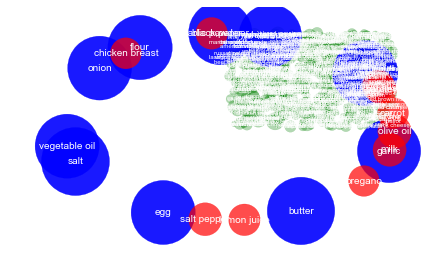

In [986]:
plt.axis('off')

nlist = [x[0] for x in sorted_x[20:]]
ndegree = [x[1] for x in sorted_x[20:]]
pos = nx.random_layout(G)

nx.draw_networkx_nodes(G,pos,nodelist=nlist, node_color="green",with_labels=False,node_size=ndegree, alpha=0.3)
#nx.draw_networkx_nodes(G,pos, node_color="blue",with_labels=True,node_size=[v * 10 for v in d.values()], alpha=0.7)
nx.draw_networkx_labels(G,pos,dict(zip(nlist,nlist)),font_size=6, font_color="white")
nx.draw_networkx_edges(G, pos,nodelist=nlist,edge_color="white");

pos = nx.shell_layout(G)
#nx.draw(G, nodelist=d.keys(), node_size=[v * 100 for v in d.values()])

nlist = [x[0] for x in sorted_x[:10]]
ndegree = [x[1] * 10 for x in sorted_x[:10]]
nx.draw_networkx_nodes(G,pos,nodelist=nlist, node_color="blue",with_labels=False,node_size=ndegree, alpha=0.9)
#nx.draw_networkx_nodes(G,pos, node_color="blue",with_labels=True,node_size=[v * 10 for v in d.values()], alpha=0.7)
nx.draw_networkx_labels(G,pos,dict(zip(nlist,nlist)),font_size=10, font_color="white")
nx.draw_networkx_edges(G, pos,nodelist=nlist,edge_color="white");

nlist = [x[0] for x in sorted_x[10:20]]
ndegree = [x[1] * 3 for x in sorted_x[10:20]]

nx.draw_networkx_nodes(G,pos,nodelist=nlist, node_color="red",with_labels=False,node_size=ndegree, alpha=0.7)
#nx.draw_networkx_nodes(G,pos, node_color="blue",with_labels=True,node_size=[v * 10 for v in d.values()], alpha=0.7)
nx.draw_networkx_labels(G,pos,dict(zip(nlist,nlist)),font_size=10, font_color="white")
nx.draw_networkx_edges(G, pos,nodelist=nlist,edge_color="white");



In [820]:
print(plt.style.available)


['seaborn-poster', 'seaborn-colorblind', 'seaborn-bright', 'grayscale', 'classic', 'seaborn-whitegrid', 'fivethirtyeight', 'seaborn-pastel', 'seaborn-paper', 'seaborn-deep', 'bmh', 'seaborn-dark-palette', 'dark_background', 'seaborn-ticks', 'seaborn-muted', 'seaborn-darkgrid', 'seaborn-dark', 'seaborn-talk', 'seaborn', 'seaborn-white', 'seaborn-notebook', 'ggplot']


# Appendix

//anaconda/envs/condap3/lib/python3.5/site-packages/matplotlib/artist.py:233: MatplotlibDeprecationWarning: get_axes has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  stacklevel=1)


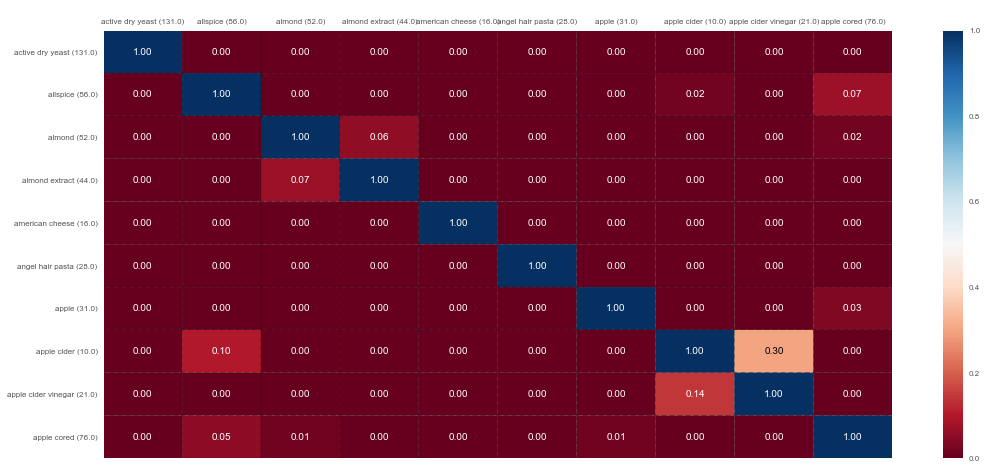

In [1340]:
plot_cooccurrence_matrix_heatmap(vocabulary[:10],cooccurrence_matrix_percentage[:10,:10])

def plot_cooccurrence_matrix_heatmap(label_headers,cooccurrence_matrix_percentage):
    label_header_with_count = [ '{0} ({1})'.format(label_header, cooccurrence_matrix_diagonal[label_number]) for label_number, label_header in enumerate(label_headers)]  
    #print('\nlabel_header_with_count: {0}'.format(label_header_with_count))
    x_axis_size = cooccurrence_matrix_percentage.shape[0]
    y_axis_size = cooccurrence_matrix_percentage.shape[1]
    title = "Co-occurrence matrix\n"
    xlabel= ''#"Labels"
    ylabel= ''#"Labels"
    xticklabels = label_header_with_count
    yticklabels = label_header_with_count
    heatmap(cooccurrence_matrix_percentage, title, xlabel, ylabel, xticklabels, yticklabels)
    
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: http://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.get_axes()
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)

def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: http://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels):
    '''
    Inspired by:
    - http://stackoverflow.com/a/16124677/395857 
    - http://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    # resize 
    fig = plt.gcf()
    fig.set_size_inches(cm2inch(40, 20))